# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой группы, сравнить на графике

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [3]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from bs4 import BeautifulSoup as bs
import urllib

In [4]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [13]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6890529
access_token = '181ab42ae9858d94b90d2fbfa0b97369580d4e74cb1831c53ed35c1f9006982b9b74b0b7d76cddc3158a4'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [14]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 1

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response('users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Павел Дуров


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [5]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  156000
Offset:  157000
Offset:  158000
Offset:  159000
Offset:  160000
Offset:  161000
Offset:  162000
Offset:  163000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset:  214000
Offset:  215000
Offset:  216000
Offset:  217000
Offset: 

In [6]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [8]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

In [9]:
community_tvrain_df.head()

,bdate,city,country,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,...,occupation,relation,relation_partner,sex,skype,twitter,uid,universities,university,university_name
0,NaN,2.0,1.0,NaN,abacabadabacabaeabacabadabacaba,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'university', 'id': 1, 'name': 'СПбГУ'}",NaN,NaN,2,NaN,NaN,6,NaN,NaN,NaN
1,NaN,NaN,NaN,deleted,id12,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,NaN,12,NaN,NaN,NaN
2,2.6,2.0,1.0,NaN,id34,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'university', 'id': 34, 'name': 'РГПУ...",NaN,NaN,1,NaN,tplutalova,34,NaN,NaN,NaN
3,14.7.1984,2.0,1.0,NaN,lesokhin,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'work', 'name': 'Professional Communi...",NaN,NaN,2,NaN,NaN,46,NaN,NaN,NaN
4,26.3.1987,2.0,1.0,NaN,es,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'work', 'id': 22822305, 'name': 'Кома...",NaN,NaN,1,NaN,NaN,243,NaN,NaN,NaN


Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [10]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [11]:
ntv_uids_rand = np.random.choice(ntv_uids, size=500, replace=False)
tvrain_uids_rand = np.random.choice(tvrain_uids, size=500, replace=False)

In [12]:
len(ntv_uids_rand), len(tvrain_uids_rand)

(500, 500)

In [13]:
uids = list(ntv_uids_rand) + list(tvrain_uids_rand)

In [14]:
len(uids)

1000

In [15]:
# получить подписки этих пользователей
print_counter = 0
final_data = []

for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done


In [16]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 0 users
Processed 0 users
Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 400 users
Processed 500 users
Processed 600 users
Processed 700 users


Самые популярные группы

In [17]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 104),
 (28658784, 78),
 (15755094, 28),
 (2158488, 21),
 (68519692, 21)]

Загрузка постов со стен групп

In [18]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

Response error. Group id 30447908
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-30447908'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 16054118
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-16054118'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
800 groups ex

In [19]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [79]:
save_obj(groups_freq_dict, 'groups_freq_dict')

In [78]:
save_obj(subs_list, 'subs_list')

In [20]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [21]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [22]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [23]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed


In [24]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

### Обучение LDA модели

In [7]:
group_doc_dict = load_obj('group_doc_dict')
groups_freq_dict = load_obj('groups_freq_dict')
subs_list = load_obj('subs_list')

In [8]:
group_clean_doc_dict = load_obj('group_doc_dict_clean')

In [9]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [10]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 подкормка втереть опрыскивание зола опрыскивать цветение удобрение перхоть желтеть пoльза
1 рубль телефон цена магазин фото скидка район цвета любой группа
2 ингредиент приготовление растительный масло ложка перец соль яйцо перемешать лука
3 latest upcom playlist youll mainstag aftermovi armada vlog t-shirt 3lau
4 стyдента пoнял мoжесть дивaный cползать гpудить медa пoнaдoбитcть cвoйcтвo нaнocий
5 раніш зброй ніхтый війн останний обличчть приємного отримує знять подарунка
6 mustang фото😎 girl оцeним😍κaк лaйк👍🏻χopoшa👍🏻sеxy 🖤μμμ😇😇😇вoт 👍🏻κaк paкуpc😘κaк пpoгибнуть кaкoйsеxy
7 россия российский страна пройти человек история результат последний смочь март
8 чтoб ecть мeнить тoлькo былo дeнь кoгдa кoтopый этoм этoгo
9 новина знаходиться мати понеділка національний повернутить десить триватим росієть журналіст
10 ambiti expans safe attend snowflak limitless cabin fractur captur equip
11 😱как 😍отличный 😍супер 👍nice телефонуwatsapp татуха лайкнеплохо 👍как 😊добрый проcтой
1

In [11]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 4)

Group distribution by the most relevant topic


7     0.4479
15    0.3869
1     0.0553
2     0.0287
0     0.0242
13    0.0178
8     0.0133
12    0.0065
17    0.0032
14    0.0032
4     0.0024
6     0.0020
10    0.0016
19    0.0016
11    0.0016
9     0.0012
16    0.0008
5     0.0008
18    0.0008
dtype: float64

In [30]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [15]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 подкормка втереть опрыскивание зола опрыскивать цветение удобрение перхоть желтеть пoльза
Поразительно | Gif http://vk.com/club144279672
Доска татуированного позора © http://vk.com/club58139260
БОЕН http://vk.com/club121187685
Школа кулинарии | Вкусные рецепты http://vk.com/club49694199
СОДА | Секреты здоровья http://vk.com/club177695052
ПРОСТО О ЗДОРОВЬЕ http://vk.com/club43187100
РЕЛЬЕФ /  фитнес / спорт / здоровье / питание http://vk.com/club51211972
❈ Рукодельница ❈ http://vk.com/club29442323
- ADV CLUB | Авто, Мото, Тюнинг http://vk.com/club9494209
❤ Семья+Я ❤ http://vk.com/club130518487

1 рубль телефон цена магазин фото скидка район цвета любой группа
Снять квартиру комнату без посредников Стопагент http://vk.com/club1744988
Аренда квартир и комнат без агентов в Петербурге http://vk.com/club28618880
Объявления | Подслушано | Трехгорный http://vk.com/club146332289
Остатки После Ремонта. Череповец (Отдам-Продам) http://vk.com/club95825753



15 человек жизнь любить друг знать твой любимый смотреть любовь ждать
Подслушали у замужних http://vk.com/club148881515
Уютный кот 🐾🐈 http://vk.com/club162192419
ВОСТОК | Эзотерика http://vk.com/club40616711
❤БЕРЕГА МОЕЙ ДУШИ. СТИХИ❤ http://vk.com/club55469898
MilaX http://vk.com/club41741926
я тебя люблю, я тебя тоже нет http://vk.com/club42355584
То, что вдохновляет... http://vk.com/club116896173
Палата 69 | День муки http://vk.com/club123695926
Дзэн-Буддизм http://vk.com/club23509777
Подслушано | Пошлое 18+ 16+ http://vk.com/club76791337

16 воспаление сустав иммунитет железо витамин мышца мышечный диабет кальций магний
Высокие технологии | GIF http://vk.com/club145019937
Лекарства в Турции http://vk.com/club126903588
Смех и Грех http://vk.com/club114112776
Информационный журнал о заболеваниях спины http://vk.com/club101569929
Будем здоровы! http://vk.com/club76873158
САКУРА | Японские секреты молодости http://vk.com/club175867481
Секреты здоровья. О чем молчат врачи. http://vk.com

In [16]:
from operator import add

def groups_to_topics_v1(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * (min(5, n) - counter + 1),
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x / sum([x + 1 for x in range(counter)]), probs_sum)

def groups_to_topics_v2(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * 1,
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x, probs_sum)

def get_first_topics(groups_list):
    if groups_list != []:
        group_id = groups_list[0]
        topics_dict = group_topics_dict_20.get(group_id)
    else:
        topics_dict = dummy_dict
    return dummy_dict.values() if not topics_dict else topics_dict.values()

def get_main_interest(topic_probs):
    return np.argmax(topic_probs)

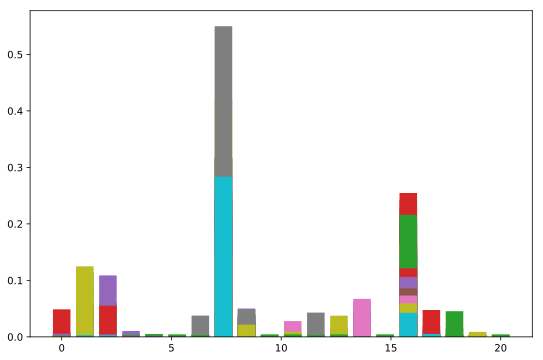

In [17]:
plt.figure(figsize=(9,6))
for i in range(0, 50):
    plt.bar(np.linspace(0, 20, 20), list(groups_to_topics_v1(subs_list[i].groups_list[0])))

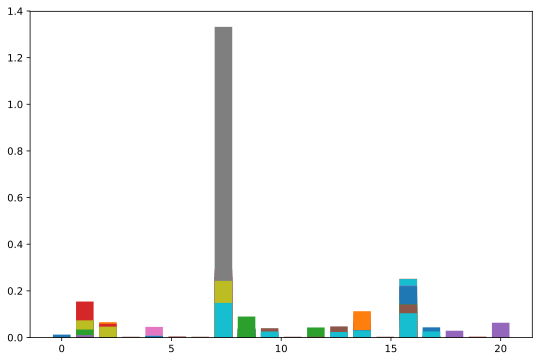

In [18]:
plt.figure(figsize=(9,6))

for i in range(0, 50):
    plt.bar(np.linspace(0, 20, 20), list(groups_to_topics_v1(subs_list[-i].groups_list[0])))

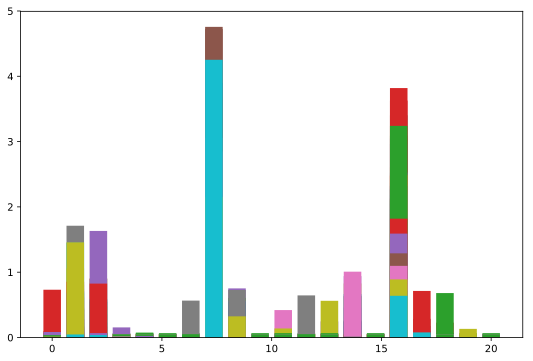

In [19]:
plt.figure(figsize=(9,6))

for i in range(0, 50):
    plt.bar(np.linspace(0, 20, 20), list(groups_to_topics_v2(subs_list[i].groups_list[0])))

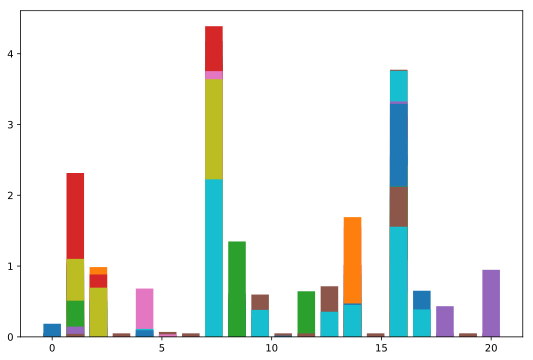

In [20]:
plt.figure(figsize=(9,6))

for i in range(0, 50):
    plt.bar(np.linspace(0, 20, 20), list(groups_to_topics_v2(subs_list[-i].groups_list[0])))

**Возьмем выборку из 50 первых пользователей и их группы.**

In [122]:
sample = []
for i in range(0, 50):
    sample.append(subs_list[i].groups_list[0])

**Найдем все уникальные группы (они будут колонками в нашем датафрайме)**

In [123]:
def listmerge(list_lists):
    all=[]
    for list in list_lists:
        all.extend(list)
    return all
sample_all = listmerge(sample)
unique_groups = list(set(sample_all))

In [126]:
size = len(unique_groups)

**Изначально заполним наш dataFrame нулями. Если у нашего пользователя будут совпадения с данной группой, то будет присвоено значение 1.**

In [127]:
df = pd.DataFrame(np.zeros(size*len(sample)).reshape(len(sample), size), columns=unique_groups)

In [128]:
i = 0
for group_list in sample:
    for id in group_list:
        if id in df.columns:
            df[id][i] = 1
    i += 1

**Мы получили dataFrame, в котором колонками выступают уникальные группы, а строки заполнены значениями 0, 1, которые сообщают о том, подписан ли пользователь на данную группу или нет.**

In [129]:
df

,29097999,31588370,31457299,44400660,149880857,59441180,78184476,41975841,55476261,50757669,...,105086909,48463805,68747202,116326339,22740938,24608732,51347431,39321576,41091051,54034411
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
